## Cost Benefit Questions
1. How would you rephrase the business problem if your model was optimising toward _precision_? i.e., How might the model behave differently and what effect would it have?
2. How would you rephrase the business problem if your model was optimising toward _recall_?
3. What would the most ideal model look like in this case?

Answers:
1. If this model where optimised toward precision, we would be minimising the number of false positives: users who are targeted in the campaign but are not retained
2. If this model where optimised toward recall, we would be minimising the number of false negatives, or making sure that users who could have retained, did
3. The model would be most optimised, at this point, towards recall, as there is the largest business gain

### Visualising models over variables

In [1]:
import pandas as pd
import sklearn.linear_model as lm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../../../../data/flight_delays.csv")
df = df.loc[df.DEP_DEL15.notnull()].copy()

In [3]:
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,CRS_DEP_TIME,DEP_TIME,DEP_DEL15,Unnamed: 15
0,1,4,2015-01-01,AA,19805,AA,12478,1247802,31703,12892,1289203,32575,900,855.0,0.0,NaN
1,1,4,2015-01-01,AA,19805,AA,12892,1289203,32575,12478,1247802,31703,900,856.0,0.0,NaN
2,1,4,2015-01-01,AA,19805,AA,12478,1247802,31703,12892,1289203,32575,1230,1226.0,0.0,NaN
3,1,4,2015-01-01,AA,19805,AA,12892,1289203,32575,12478,1247802,31703,1220,1214.0,0.0,NaN
4,1,4,2015-01-01,AA,19805,AA,11298,1129803,30194,12173,1217302,32134,1305,1754.0,1.0,NaN


In [3]:
df = df[df.DEP_DEL15.notnull()]
df = df.join(pd.get_dummies(df["CARRIER"], prefix = "carrier"))
df = df.join(pd.get_dummies(df["DAY_OF_WEEK"], prefix = "dow"))
model = lm.LogisticRegression()
features = [i for i in df.columns if "dow_" in i]

NameError: name 'df' is not defined

In [4]:
df.shape

NameError: name 'df' is not defined

In [6]:
features += ["CRS_DEP_TIME"]
model.fit(df[features[1:]], df["DEP_DEL15"])

df["probability"] = model.predict_proba(df[features[1:]]).T[1]

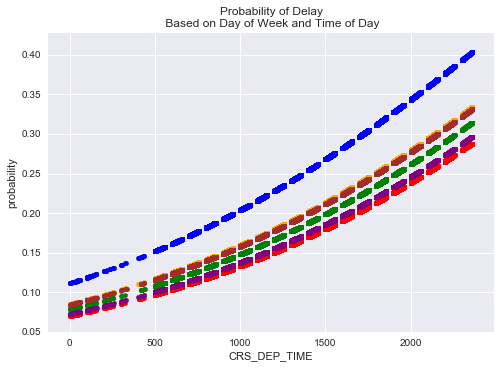

In [7]:
ax = plt.subplot(111)
colors = ["blue", "green", "red", "purple", "orange", "brown"]
for e, c in enumerate(colors):
    df[df[features[e]] == 1].plot(x = "CRS_DEP_TIME",
                                  y = "probability",
                                  kind = "scatter",
                                  color = c,
                                  ax = ax)
ax.set(title = "Probability of Delay\n Based on Day of Week and Time of Day")
plt.show()

### Other Answers: Visualising Airline performance over time; Visualising the inverse

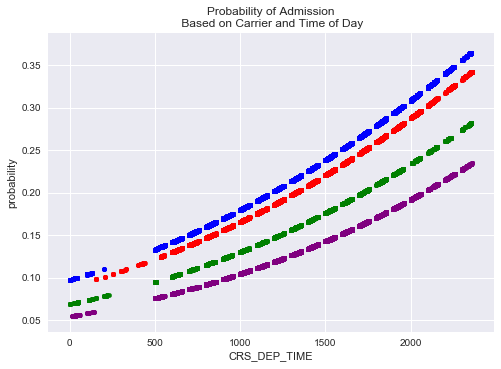

In [8]:
features = [i for i in df.columns if "carrier_" in i]
features += ["CRS_DEP_TIME"]
model = lm.LogisticRegression()
model.fit(df[features[1:]], df["DEP_DEL15"])

df["probability"] = model.predict_proba(df[features[1:]]).T[1]

ax = plt.subplot(111)
colors = ["blue", "green", "red", "purple"]
for e, c in enumerate(colors):
    df[df[features[e]] == 1].plot(x = "CRS_DEP_TIME",
                                  y = "probability",
                                  kind = "scatter",
                                  color = c,
                                  ax = ax)
ax.set(title = "Probability of Admission\n Based on Carrier and Time of Day")
plt.show()

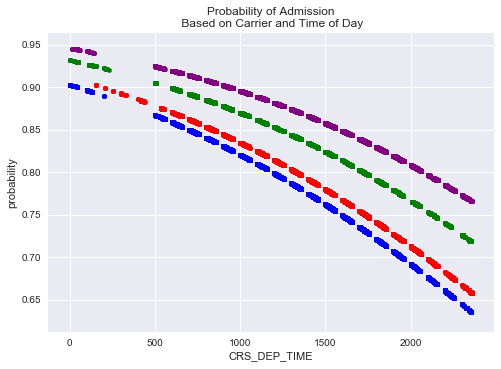

In [9]:
features = [i for i in df.columns if "carrier_" in i]
features += ["CRS_DEP_TIME"]
model = lm.LogisticRegression()
model.fit(df[features[1:]], df["DEP_DEL15"])

df["probability"] = model.predict_proba(df[features[1:]]).T[0]

ax = plt.subplot(111)
colors = ["blue", "green", "red", "purple"]
for e, c in enumerate(colors):
    df[df[features[e]] == 1].plot(x = "CRS_DEP_TIME",
                                  y = "probability",
                                  kind = "scatter",
                                  color = c,
                                  ax = ax)
ax.set(title = "Probability of Admission\n Based on Carrier and Time of Day")
plt.show()

## Visualising Performance Against Baseline

### Visualising AUC and comparing Models

In [10]:
from sklearn import dummy, metrics

In [11]:
model0 = dummy.DummyClassifier()
model0.fit(df[features[1:]], df["DEP_DEL15"])
df["probability_0"] = model0.predict_proba(df[features[1:]]).T[1]

model1 = lm.LogisticRegression()
model.fit(df[features[1:]], df["DEP_DEL15"])
df["probability_1"] = model.predict_proba(df[features[1:]]).T[1]

In [12]:
df.shape

(458311, 40)

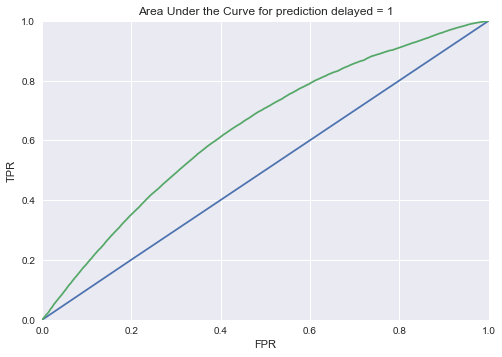

In [13]:
ax = plt.subplot(111)
vals = metrics.roc_curve(df.DEP_DEL15, df.probability_0)
ax.plot(vals[0], vals[1])
vals = metrics.roc_curve(df.DEP_DEL15, df.probability_1)
ax.plot(vals[0], vals[1])

ax.set(title = "Area Under the Curve for prediction delayed = 1",
       xlabel = "FPR",
       ylabel = "TPR",
       xlim = (0, 1),
       ylim = (0, 1))
plt.show()

### Visualising Precision / Recall (with cleaner code)

In [14]:
model0 = dummy.DummyClassifier()
model0.fit(df[features[1:]], df.DEP_DEL15)
df["probability_0"] = model0.predict_proba(df[features[1:]]).T[1]

model = lm.LogisticRegression()
model.fit(df[features[1:]], df.DEP_DEL15)
df["probability_1"] = model.predict_proba(df[features[1:]]).T[1]

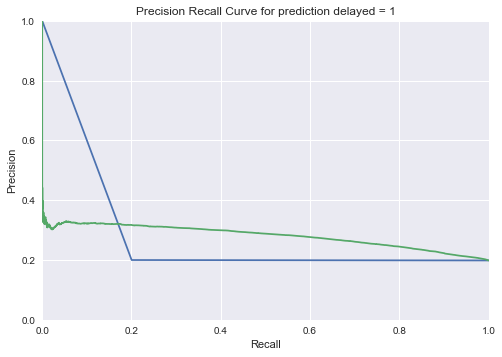

In [15]:
ax = plt.subplot(111)
for i in range(2):
    vals = metrics.precision_recall_curve(df.DEP_DEL15, df["probability_" + str(i)])
    ax.plot(vals[1], vals[0])

ax.set(title = "Precision Recall Curve for prediction delayed = 1",
       xlabel = "Recall",
       ylabel = "Precision",
       xlim = (0, 1),
       ylim = (0, 1))
plt.show()